<center>
<img src="https://compu-flair.com/wp-content/uploads/2022/06/CompuFlairLogo.png" width="500" alt="Python Index" />
<div style="font-size:20px">CompuFlair L.L.C.</div>
<div><a href="https://compu-flair.com">www.compu-flair.com</a></div>
<div><a href="mailto:contact@compu-flair.com">contact@compu-flair.com</a></div>
<hr style="width:80%;height:5px;border-width:0;color:gray;background-color:#374682">
</center>

# Differentially Expressed Genes Analysis of Proteomics Data with Python: Step 1

### Identify Outliers &  Between and Within Sample Variabilities

##### (Using Principal Component Analysis)

First, import the packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [26]:
## Plot settings
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
labelsize = 14
font = {
	'family': 'serif',
	'size': 16,
	'style': 'normal',
	'weight': 'medium',
	'fontname': 'Arial'
}
my_dpi = 80
width  = 6.4*my_dpi # in pixel
height = 4.8*my_dpi # in pixel

## Import Data

To run this analysis, you need to prepare your data into the following form and upload them here.  

* A CSV file named Proteins.csv. There should be only one column. The header should be NAME. The rows are the genes that are expressed and quantified. 
* A CSV file named control.csv. This file contains the gene expression data before the treatment. The corresponding rows in this file and Proteins.csv shall refer to the same proteins. There are as many columns as your number of replicas/samples. Name the headers control1, control2, ...
* A CSV file named case.csv. This file contains the gene expression data after the treatment. The rows of this file and Proteins.csv shall refer to the same proteins. There are as many columns as the number of your replica/samples. Name the headers drug1, drug2, ...

<img src="https://compu-flair.com/wp-content/uploads/2022/08/DataPreparation-1.png"/>

In [ ]:
## If you don't have a data yet, run this block to download our sample dataset
# ????

In [2]:
df_bef = pd.read_csv("control.csv", skiprows = 0)
df_aft = pd.read_csv("case.csv", skiprows = 0)
df_nam = pd.read_csv("Proteins.csv", skiprows = 0)

In [3]:
## make sure the size of files are consistent
if (df_bef.index.size != df_nam.index.size) or (df_aft.index.size != df_nam.index.size):
    raise(Exception("data files are not consistent"))

##### Calculate and observe the statistics of control data

In [4]:
df_bef.describe()

,control1,control2,control3
count,3900.000000,3900.000000,3900.000000
mean,767.641303,767.697632,767.281957
std,2451.153135,2500.362725,2477.971295
min,4.300000,3.900000,4.100000
25%,44.350000,42.837500,43.287500
50%,133.000000,129.416667,131.083333
75%,511.275000,508.016667,509.591667
max,47683.133333,51663.433333,47841.233333


##### Calculate and observe the statistics of case data

In [5]:
df_aft.describe()

,drug1,drug2,drug3
count,3900.000000,3900.000000,3900.000000
mean,760.933175,758.683318,759.988423
std,2596.267880,2640.936767,2610.903026
min,2.500000,2.600000,2.700000
25%,40.350000,39.675000,39.366667
50%,120.683333,116.250000,120.441667
75%,486.750000,472.581250,489.191667
max,68071.633333,69468.000000,69251.000000


Handle the missing values

In [6]:
if df_bef.isna().sum().sum() > 0: 
    replace = input("Nan value exist in control. Replacing with medians? (y/n) \n")
    if replace == "y":
        df_bef.fillna(df_bef.median(axis=1), inplace=True)
    else:
        raise(Exception("Resolve nan values"))
        
if df_aft.isna().sum().sum() > 0: 
    replace = input("Nan value exist in case. Replacing with medians? (y/n) \n")
    if replace == "y":
        df_aft.fillna(df_aft.median(axis=1), inplace=True)
    else:
        raise(Exception("Resolve nan values"))

In [9]:
## get the columns of the control and case datasets
cols_bef = list(df_bef)
cols_aft = list(df_aft)
print (cols_bef , cols_aft)

['control1', 'control2', 'control3'] ['drug1', 'drug2', 'drug3']


Compute p-values to identify differentially expressed genes (DEG)

In [10]:
## -1 means no p-value 
p_vals = -np.ones(df_bef.index.size)

if len(cols_bef) > 2 and len(cols_aft) >2:
    #stats.ttest_ind(x, y)
    for i in range(df_bef.index.size):
        p_vals[i] = stats.ttest_ind(list(df_bef.iloc[i]), list(df_aft.iloc[i]) ).pvalue;   
    
print(f"p-values: {p_vals}")

p-values: [2.54265799e-05 1.03718062e-02 7.81223509e-07 ... 2.54560714e-03
 5.02966009e-05 1.11712336e-01]


Calculate the average of each gene in the control and case separately. Also, calculate their differences to identify DEG

In [14]:
avg_exp_bef = df_bef.mean(axis = 1)
avg_exp_aft = df_aft.mean(axis = 1)

diff = avg_exp_aft - avg_exp_bef;

Calculate the fold changes

In [15]:
folds = avg_exp_aft/avg_exp_bef

Set P-value and k-folds thresholds to identify DEG. The following numbers are standard. Change them if you know what you are doing.

In [18]:
df_analysis_inpput = pd.DataFrame({
    'kfold up-regulated'  : [1.2],
    'kfold down-regulated': [0.83],
    'p-value'             : [0.05],
    'species'             : ['Homo sapiens']
})
df_analysis_inpput

,kfold up-regulated,kfold down-regulated,p-value,species
0,1.2,0.83,0.05,Homo sapiens


Apply the thresholds and curate the genes, i.e. find DEG

In [19]:
mask = ((    (folds > df_analysis_inpput['kfold up-regulated'].values[0]) 
             | #or
             (folds < df_analysis_inpput['kfold down-regulated'].values[0])
        )
        & #and
        (p_vals < df_analysis_inpput['p-value'].values[0])
       )

## List of differentially expressed genes (DEG)

In [21]:
df_nam.loc[mask,:].T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,164,165,166,167,168,170,171,174,175,176,178,179,180,181,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,199,201,202,203,204,205,206,207,208,209,210,212,213,214,215,216,217,218,219,220,221,222,224,225,226,227,228,229,230,231,232,233,234,235,236,238,239,242,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,348,349,350,351,354,355,357,358,359,360,361,362,363,364,366,367,368,369,370,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,394,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,419,420,421,422,424,425,426,427,429,430,431,432,434,435,436,437,438,439,441,442,443,444,445,446,447,448,449,450,451,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,481,482,483,485,486,487,489,490,492,493,495,496,497,498,499,500,501,503,506,507,508,509,510,512,513,514,515,516,518,519,520,521,522,523,524,525,526,527,528,530,531,532,533,534,536,537,538,539,540,541,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,563,564,565,566,567,569,570,571,573,575,577,579,580,582,583,584,585,586,589,591,593,594,596,597,598,599,600,601,602,603,606,608,609,610,612,614,615,618,619,621,622,623,624,628,629,630,631,632,634,635,636,638,639,640,641,642,643,644,646,648,650,651,652,653,654,656,657,658,659,660,661,662,663,664,665,668,671,672,673,674,675,677,678,679,680,681,682,683,685,686,688,690,691,692,693,695,696,698,699,701,702,703,706,707,709,713,714,716,717,718,719,720,721,723,724,725,726,727,729,730,731,732,733,734,735,736,738,739,744,745,746,747,748,752,753,756,758,759,760,761,762,763,766,767,768,770,771,772,773,774,775,778,779,780,781,783,784,788,791,792,794,800,801,802,807,809,810,811,814,815,816,817,818,819,822,823,824,826,827,828,829,830,832,833,835,836,837,839,843,845,847,851,852,853,854,858,859,860,861,866,867,868,871,877,880,882,885,886,888,890,891,892,894,898,899,900,906,907,908,913,914,916,918,919,924,925,931,932,935,936,939,940,941,942,944,947,950,954,955,959,962,965,967,968,970,973,974,975,985,995,996,999,1000,1007,1010,1015,1018,1019,1023,1032,1034,1037,1043,1044,1046,1047,1050,1057,1058,1060,1062,1064,1068,1072,1075,1082,1084,1089,1102,1109,1111,1121,1125,1133,1147,1157,1180,1221,1270,1330,1358,1380,1383,1410,1498,1526,1595,2439,2825,2829,2907,3036,3073,3113,3176,3185,3189,3202,3250,3260,3286,3297,3306,3316,3319,3330,3340,3348,3351,3353,3359,3360,3363,3364,3382,3383,3407,3410,3411,3416,3420,3423,3424,3426,3428,3429,3430,3432,3433,3435,3436,3439,3440,3445,3446,3461,3464,3465,3467,3471,3473,3477,3481,3482,3484,3488,3492,3493,3494,3495,3496,3497,3498,3499,3503,3505,3506,3509,3511,3512,3513,3514,3516,3518,3521,3522,3523,3524,3525,3526,3527,3528,3529,3531,3533,3537,3538,3539,3542,3543,3546,3548,3549,3550,3552,3554,3555,3556,3557,3558,3560,3561,3562,3565,3566,3567,3568,3571,3572,3573,3574,3575,3578,3579,3580,3581,3582,3583,3584,3587,3588,3589,3591,3592,3593,3594,3596,3597,3598,3600,3603,3604,3605,3607,3608,3609,3610,3614,3615,3616,3617,3618,3620,3622,3623,3625,3626,3627,3628,3630,3632,3633,3635,3636,3637,3638,3639,3640,3641,3642,3643,3646,36

Write the list of DEG 

In [20]:
df_nam.loc[mask,:].to_csv("DEP.csv", index=None)

## Principal component analysis (PCA) plot

Principal component analysis (PCA) provides an overall analysis of changes in proteins, or genes, between and within the experimental conditions. Through this analysis, we would like to make sure that the former change is significantly larger than the latter change. Principal components can be viewed as a set of independent hypothetical genes that are sorted based on their variability. Usually, the first few principal components describe the most variation in the data. (Koch et al. 2018)

In [22]:
## Dataset with genes being features as columns and samples or replicates as rows
X = np.array(pd.concat([df_bef.loc[mask,:],df_aft.loc[mask,:]],axis=1, ignore_index=True)).T

PCA works best on a normalized dataset. Conventional normalization is to subtract the mean of gene expressions from them and divide by the standard deviation. This is don in the following line.

In [30]:
pip = Pipeline([('scaler',StandardScaler()),('pca',PCA())])
pip.fit(X)
X_trans = pip.transform(X)

This plot shows the variance of each principal component (PC). The first principal component contains the largest variance of the dataset, the second principal component contains the second largest variance, etc.

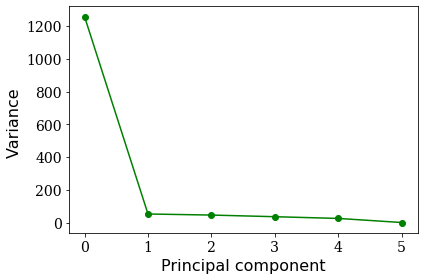

In [31]:
fig, ax = plt.subplots()
ax.plot(pip.named_steps.pca.explained_variance_,'-og')
ax.set_xlabel(f"Principal component",fontdict=font)
ax.set_ylabel("Variance ",fontdict=font)
ax.tick_params(labelsize=labelsize)
plt.tight_layout()
plt.show()

This plot shows the cumulative variance stored in the principal components.

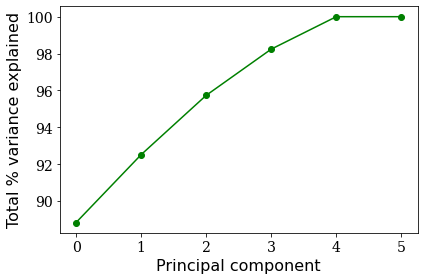

In [28]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(pip.named_steps.pca.explained_variance_ratio_)*100,'-og') ## cumulative sum
ax.set_ylabel("Total % variance explained",fontdict=font)
ax.set_xlabel("Principal component",fontdict=font)
ax.tick_params(labelsize=labelsize)
plt.tight_layout()
plt.show()

Usually the the first two PC should explain most of the variation in the data. See if that is the case

In [29]:
if np.cumsum(pip.named_steps.pca.explained_variance_ratio_)[1] > 0.8:
    print("More than 80% of variation is explained by the first 2 principal component.")

print(f"\npercentage of variability:\n\
                           1st pc: {np.round(pip.named_steps.pca.explained_variance_ratio_[0]*100,1)}% \n\
                           2nd pc: {np.round(pip.named_steps.pca.explained_variance_ratio_[1]*100,1)}%")

More than 80% of variation is explained by the first 2 principal component.

percentage of variability:
                           1st pc: 88.8% 
                           2nd pc: 3.7%


We usually plot the first principal component, containing the largest change, versus the second principal component, containing the second largest change. An ideal dataset has a PCA plot in which the samples under the same experimental conditions are very close to each other while samples under different experimental conditions are far away. (Koch et al. 2018)

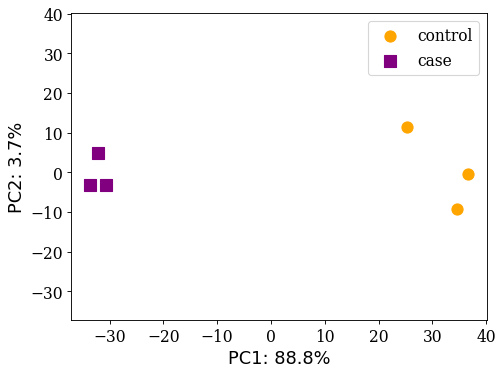

In [33]:
#fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
ax.scatter(X_trans[:df_bef.shape[1],0], X_trans[:df_bef.shape[1],1],c='orange',label='control',marker='o',s=100)
ax.scatter(X_trans[df_bef.shape[1]:,0], X_trans[df_bef.shape[1]:,1],c='purple',label='case',marker='s',s=100)
dn = min(ax.get_xlim()[0], ax.get_ylim()[0])
up = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(dn,up)
ax.set_ylim(dn,up)
ax.set_xlabel(f"PC1: {np.round(pip.named_steps.pca.explained_variance_ratio_[0]*100,1)}%", fontdict=font)
ax.set_ylabel(f"PC2: {np.round(pip.named_steps.pca.explained_variance_ratio_[1]*100,1)}%", fontdict=font)
ax.legend(prop={'size': 14})
ax.tick_params(labelsize=labelsize)
plt.tight_layout()
plt.show()